# **Learning to See Programming Challenge Instructions**

![](graphics/finger_counting_demo.gif)

## The Challenge and Data

Your mission is to write a computer vision algorithm to count the number fingers in an image from a [Leap Motion](https://www.leapmotion.com/) Infrared Camera. In this repository you'll find a pickle file containing 42 training examples.

In [1]:
%pylab inline
import pickle
import sys

sys.path.append('../util')
from data_handling import extractFeatures
from image import makeGrayScale

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Load data:
with open('../data/training_data.p', 'rb') as f:
    d = pickle.load(f)

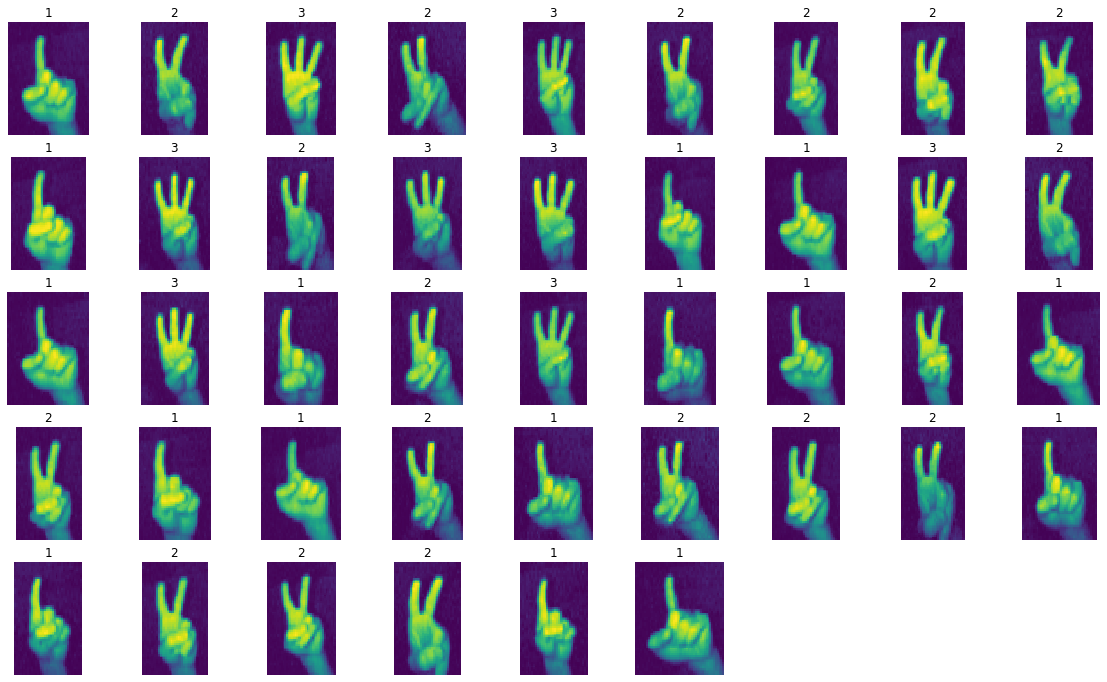

In [3]:
fig = figure(0, (20, 12))

for i in range(len(d)):
    fig.add_subplot(5, 9, i+1)
    
    cropped_image = d[i]['image'][d[i]['boxEdges'][2]:d[i]['boxEdges'][3], \
                                       d[i]['boxEdges'][0]:d[i]['boxEdges'][1]] 
    
    imshow(cropped_image)
    title(str(d[i]['numFingers']))
    axis('off')

## **The Data**

In addition to images and labels, the dataset also includes some other helpful information.

In [4]:
#Data is stored as a list of dicts:
len(d)

42

In [5]:
d[0].keys()

dict_keys(['box', 'boxHeight', 'handPoints', 'trackingIndices', 'allFingerPoints', 'boxWidth', 'image', 'boxEdges', 'croppedImage', 'numFingers', 'numPointsInBox', 'handEdges', 'indexFingerPoints', 'picCount', 'image1bit'])

Perhaps the most helpful information is finger pixel labels:

In [6]:
exampleIndices = [7, 30, 38]

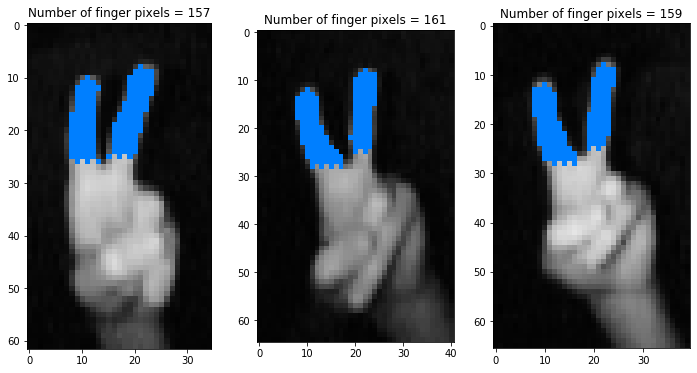

In [7]:
fig = figure(0, (12, 6))

for i in range(3):
    fig.add_subplot(1,3,i+1)
    imageDict = d[exampleIndices[i]]
    
    X1, y1 = extractFeatures(imageDict, whichImage = 'image1bit', dist = 4)    
    yImage = y1.reshape(imageDict['boxHeight'], imageDict['boxWidth'])
    
    im = makeGrayScale(imageDict)
    
    #Paint with matches:
    im[:,:,0][yImage==1] = 0
    im[:,:,1][yImage==1] = .5
    im[:,:,2][yImage==1] = 1
    
    imshow(im, interpolation = 'none')
    title('Number of finger pixels = ' + str(sum(y1==1)))

As you'll see in this series, these labels can be used to train a finger pixel classifier.

## **A Little Guidance**

In [8]:
from viz import showMatches, bw, rw, rwb, testLogicalRules
from data_handling import breakIntoGrids, reshapeIntoImage

In this challenge, you will be writing a  `count_fingers` method will be passed a series of grayscale images like this:

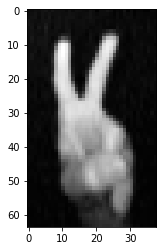

In [9]:
i = 1
grayscale_image = d[i]['image'][d[i]['boxEdges'][2]:d[i]['boxEdges'][3], d[i]['boxEdges'][0]:d[i]['boxEdges'][1]] 
imshow(grayscale_image, cmap = 'gray')

- Your job is to count the number of fingers being held up. 
- To determine if a given pixel in the image shows a finger or not, you can follow the pipeline we'll build out in this course. 
- First we threshold the image.

In [10]:
im = grayscale_image > 92

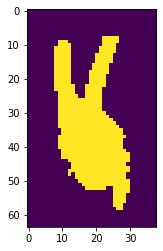

In [11]:
imshow(im)

And then break up the image into 9x9 grids:

In [12]:
X = breakIntoGrids(im, s = 9)

In [13]:
X.shape

(1680, 81)

- We then use a rule that we learned using a decision tree to determine if a given 9x9 grid of pixels shows a finger or not.
- You are welcome to train your own decision tree (you could even train on grayscale, non-thresholded images to improve perforamance, however you should be able to get good performance just using the rule or rules we learn in the lectures. 
- One of the best rules our decision tree spits out looks like this:

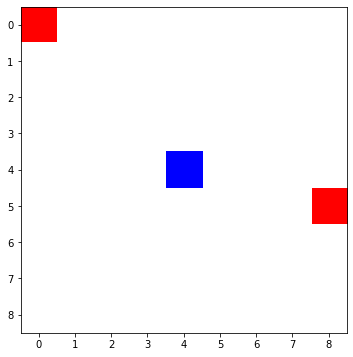

In [14]:
treeRule1 = lambda X: np.logical_and(np.logical_and(X[:, 40] == 1, X[:,0] == 0), X[:, 53] == 0)

ruleVector = np.zeros(81); ruleVector[40] = 1; ruleVector[0] = -1; ruleVector[53] = -1
fig = figure(0, (6,6)); imshow(ruleVector.reshape(9,9), interpolation = 'none', cmap = rwb)

We can process our matrix of 9x9 image grids like this:

In [15]:
yhat = treeRule1(X)

In [16]:
#Our vector of predictions for each pixel:
yhat

array([False, False, False, ..., False, False, False])

Reshape our predictions back into an image using a method we've provided in `data_handling.py`:

In [17]:
yhat_reshaped = reshapeIntoImage(yhat, im.shape)

Text(0.5, 1.0, 'After "Finger Detection"')

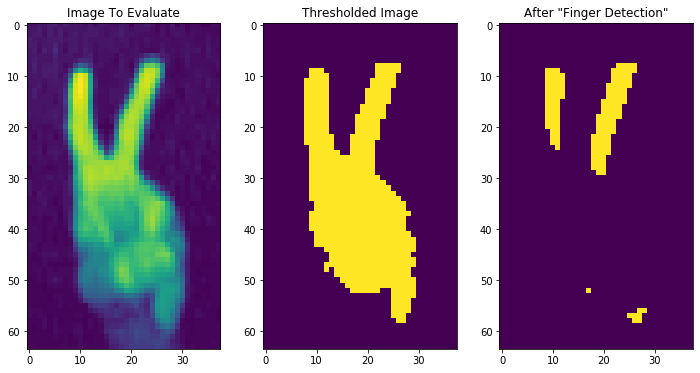

In [18]:
fig = figure(0, (12, 6))
fig.add_subplot(1,3,1); imshow(grayscale_image); title('Image To Evaluate')
fig.add_subplot(1,3,2); imshow(im); title('Thresholded Image')
fig.add_subplot(1,3,3); imshow(yhat_reshaped); title('After "Finger Detection"')

- Notice that our finger detector isn't perfect, you are welcome to create a better finger pixel detector, but you should be able to achieve > 80% accuracy using the pipeline we've shown here. 
- Just like all the code developed in this module, you are free to use this code in your solution. 
- Now, the final step here is to figure out how to count the number of fingers in the `yhat_reshaped` image. 
- There are lots of possible approaches here, in the original video series, I tried to count the number of seperate connected regions of detections, and any connected region with more than X (some threshold) pixels, I called a finger.
- One way to do this is: 
    1. Randomly select a finger pixel detection in `yhat_reshaped`
    2. Search the adjacent pixels for more detections, if you find an adjacent detection that is a finger pixel, add this to your "blob", and then test this pixel. 
    3. Keep growing your blob in this way, until your find the edges. 
- You'll need to add some logic to deal with the cases where you randomly pick two seeds in the same blob
- If your code works correctly, you should end up with a list of seperate blobs, and the number of pixels in each. 
- From there, you should be able to write some simple rules that allow you to count the number of fingers. 
- **Good Luck!**

## **Evaluation**

Checkout `sample_student.py` for an example submission script. Your submission will be evaluated with `evaluate.py` on a held-out testing set.

In [19]:
from evaluate import evaluate

In [20]:
accuracy, confustion_matrix = evaluate(student_file = 'sample_student', data_file = '../data/training_data.p')

                  Correct Labels  
                  1      2      3
                 -----------------
Predicted     1 | 5      3      8      
Labels        2 | 4      4      10      
              3 | 2      2      4      


Accuracy = 0.31


## **Grading**

This assignment is worth a maxiumum of 10 points.

---


| Accuracy | Points |
| ------------- |:-------------:| 
| >= 0.8         | 10 | 
| 0.7 <= a < 0.8  | 9/10|  
| 0.6 <= a < 0.7 | 8/10 |   
| 0.5 <= a < 0.6 | 7/10 | 
| 0.4 <= a < 0.5 | 6/10 | 
| 0.35 <= a < 0.4 | 5/10 | 
| a < 0.35 | 4/10 |
| Non-running code | 0/10|

# **Good Luck!**